https://qiita.com/kazuya_minakuchi/items/186b20efd0eefdeb026b#%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0 の図を作ったコード

※ほとんど「機械学習のエッセンス: https://www.amazon.co.jp/gp/product/4797393963/ref=ppx_yo_dt_b_search_asin_title 」の写経

In [1]:
#必要なライブラリインポート
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
#線形回帰のクラス
class LinearRegression:
    def __init__(self):
        self.w_ = None
    
    #教師データから係数計算する
    def fit(self, X, t):
        #xに定数項加える
        Xtil = np.c_[np.ones(X.shape[0]), X]
        #行列使って係数を計算
        A = np.dot(Xtil.T, Xtil)
        b = np.dot(Xtil.T, t)
        self.w_ =linalg.solve(A, b)
    
    #xからyを予測(fit後に使う)
    def predict(self, X):
        if X.ndim ==1:
            X = X.reshape(1, -1)
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)

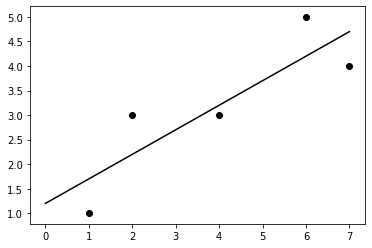

In [3]:
x = np.array([1, 2, 4, 6, 7])
y = np.array([1, 3, 3, 5, 4])
plt.scatter(x, y, color="k")

model = LinearRegression()
model.fit(x, y)

xmax = x.max()
plt.plot([0, xmax],
         [model.predict(np.array([0])), model.predict(np.array([xmax]))],
         color="k")
plt.show()

In [4]:
#多項式近似
class PolynomialRegression:
    #次数決定
    def __init__(self, degree):
        self.degree = degree
    
    #教師データから係数計算する
    def fit(self, regressor, x, y):
        x_pow = []
        xx = x.reshape(len(x), 1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
        mat = np.concatenate(x_pow, axis=1)
        regressor.fit(mat, y)
        self.w_ = regressor.w_
    
    #xからyを予測(fit後に使う)
    def predict(self, x):
        r = 0
        for i in range(self.degree + 1):
            r += x**i * self.w_[i]
        return r

In [5]:
np.random.seed(0)

def f(x):
    return 1 + 2 * x

#データ生成
x = np.random.random(10) * 10
y = f(x) + np.random.randn(10)

C:\Users\kazuy\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: LinAlgWarning: Ill-conditioned matrix (rcond=3.44759e-31): result may not be accurate.
  del sys.path[0]


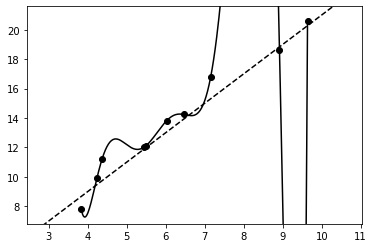

In [6]:
plt.scatter(x, y, color="k")

x1 = x.min() - 1
x2 = x.max() + 1
plt.plot([x1, x2], [f(x1), f(x2)], color="k", linestyle="dashed")

#多項式近似
model = PolynomialRegression(10) #10次式
model.fit(LinearRegression(), x, y)
plt.ylim([y.min() - 1, y.max() + 1])
xx = np.linspace(x.min(), x.max(), 300)
yy = np.array([model.predict(u) for u in xx])
plt.plot(xx, yy, color="k")

plt.show()

In [7]:
#リッジ回帰
class RidgeRegression:
    def __init__(self, lambda_=1.):
        self.lambda_ = lambda_
        self.w_ = None
    
    #教師データから係数計算する
    def fit(self, X, t):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        c = self.lambda_ * np.eye(Xtil.shape[1]) #ハイパーパラメータ×単位行列
        A = np.dot(Xtil.T, Xtil) + c
        b = np.dot(Xtil.T, t)
        self.w_ = linalg.solve(A, b)
    
    #xからyを予測(fit後に使う)
    def predict(self, X):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)

C:\Users\kazuy\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: LinAlgWarning: Ill-conditioned matrix (rcond=1.0006e-20): result may not be accurate.
  if sys.path[0] == '':


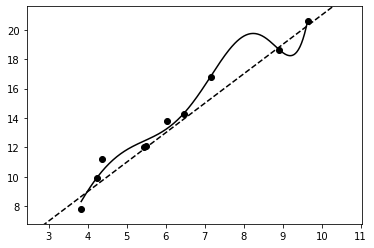

In [8]:
plt.scatter(x, y, color="k")

x1 = x.min() - 1
x2 = x.max() + 1
plt.plot([x1, x2], [f(x1), f(x2)], color="k", linestyle="dashed")

#多項式近似
model = PolynomialRegression(10) #10次式
model.fit(RidgeRegression(), x, y)
plt.ylim([y.min() - 1, y.max() + 1])
xx = np.linspace(x.min(), x.max(), 300)
yy = np.array([model.predict(u) for u in xx])
plt.plot(xx, yy, color="k")

plt.show()

In [9]:
#リッジ回帰
def soft_thresholding(x, y):
    return np.sign(x) * max(abs(x) - y, 0)

class Lasso:
    def __init__(self, lambda_, tol=0.0001, max_iter=1000):
        self.lambda_ = lambda_
        self.tol = tol
        self.max_iter = max_iter
        self.w_ = None
    
    #教師データから係数計算する
    def fit(self, X, t):
        n, d = X.shape
        self.w_ = np.zeros(d + 1)
        avgl1 = 0.
        #リッジは手計算では解けないので繰り返し計算で解を求める
        for _ in range(self.max_iter):
            avgl1_prev = avgl1
            self._update(n, d, X, t)
            avgl1 = np.abs(self.w_).sum() / self.w_.shape[0]
            if abs(avgl1 - avgl1_prev) <= self.tol:
                break
    
    def _update(self, n, d, X, t):
        self.w_[0] = (t - np.dot(X, self.w_[1:])).sum() / n
        w0vec = np.ones(n) * self.w_[0]
        for k in range(d):
            ww = self.w_[1:]
            ww[k] = 0
            q = np.dot(t - w0vec - np.dot(X, ww), X[:, k])
            r = np.dot(X[:, k], X[:, k])
            self.w_[k + 1] = soft_thresholding(q / r, self.lambda_)
    
    #xからyを予測(fit後に使う)
    def predict(self, X):
        if X.ndim ==1:
            X = X.reshape(1, -1)
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)

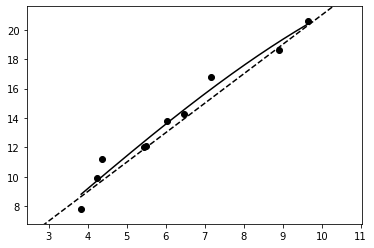

In [10]:
plt.scatter(x, y, color="k")

x1 = x.min() - 1
x2 = x.max() + 1
plt.plot([x1, x2], [f(x1), f(x2)], color="k", linestyle="dashed")

#多項式近似
model = PolynomialRegression(10) #10次式
model.fit(Lasso(lambda_=0.00001), x, y)
plt.ylim([y.min() - 1, y.max() + 1])
xx = np.linspace(x.min(), x.max(), 300)
yy = np.array([model.predict(u) for u in xx])
plt.plot(xx, yy, color="k")

plt.show()